이미지를 처리하기 앞서, 다뤄야할 이미지의 확장자가 dcm으로 되어있는 것을 확인. 이를 불러오고 처리하기 위해 어떤 확장자인지 알아봤다.


DICOM은 의료용 디지털 영상 및 통신 표준으로 의료용 기기에서 디지털 영상표현과 통신에 사용되는 여러가지 표준을 총칭하는 말이다. 일반 RGB 이미지가 픽셀값(0~255)로 이루어진 것과는 다르게 dicom 파일을 구성하고 있는 픽셀값은 (-x ~ +x)와 같이 범위가 마이너스부터 시작되는 경우도 있고, bit epth가 12bit, 16bit로 구성되어있는 경우도 있다고 한다.

예를 들어 CT에는 Hounsfield Unit(HU)라는 단위가 있고, 이 HU는 X선이 몸을 투과할 때 감쇠되는 정도를 나타내는 단위라 한다. 물을 통과할 때를 0으로 둔채 상대값으로 표현하는 것으로, 보고싶은 신체 부위가 있다면 HU table을 참고해 Window Center(보고싶은 부위의 HU값)와 Window Width(WC를 중심으로 관찰하고자 하는 HU 번위)를 조절한 뒤 그 부분을 위주로 출력해 줄 수 있다. 예를들어 HU table상 폐는 -600 ~ -400이므로 Window Center는 -600으로 잡고, Window Width는 1600으로 잡아주면 되는 것이다.

In [10]:
# 파이썬으로 DICOM 파일을 다룰 수 있도록 도와주는 library
! pip install pylibjpeg pylibjpeg-libjpeg pydicom pylibjpeg-openjpeg

In [2]:
from pydicom import dcmread
import pydicom
import pylibjpeg

In [12]:
# 라이브러리가 제대로 작동하는지 알아보기 위해 test_img 뽑아보기

test_img = './Chest_Xray/train/0007d316f756b3fa0baea2ff514ce945.dicom'
dcm = pydicom.dcmread(test_img)

In [8]:
# 받아온 이미지의 속성 정보 중 하나 받아오기
dcm.PatientSex

NameError: name 'dcm' is not defined

In [9]:
import matplotlib.pyplot as plt

# 읽어온 dcm을 pixel_array에 넣어서 시각적 이미지로 확인하기
img = dcm.pixel_array
plt.imshow(img, cmap = plt.cm.bone)

NameError: name 'dcm' is not defined

DICOM을 처리하는 코드의 순서는 대략 아래와 같다고 한다
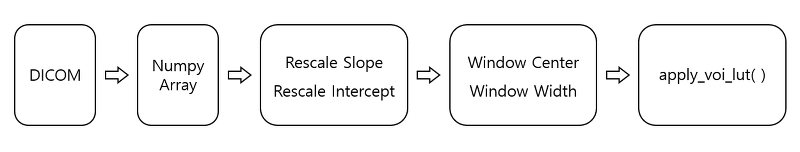
[출처 : DICOM 파일 읽는 법](https://ballentain.tistory.com/53)

위와 같이 읽어서 출력하는 모습은 DICOM Viewer로 출력한 이미자와는 차이가 발생할 수 있기 때문에 꼭 `Rescale Slppe, WindowCenter`와 같은 속성을 적용해 주어야 한다고 한다. 미세한 차이라도 실제 이미지에 적용하였을 때의 오류와 오차를 최대한 줄여하 하기 때문으로 이해했다.

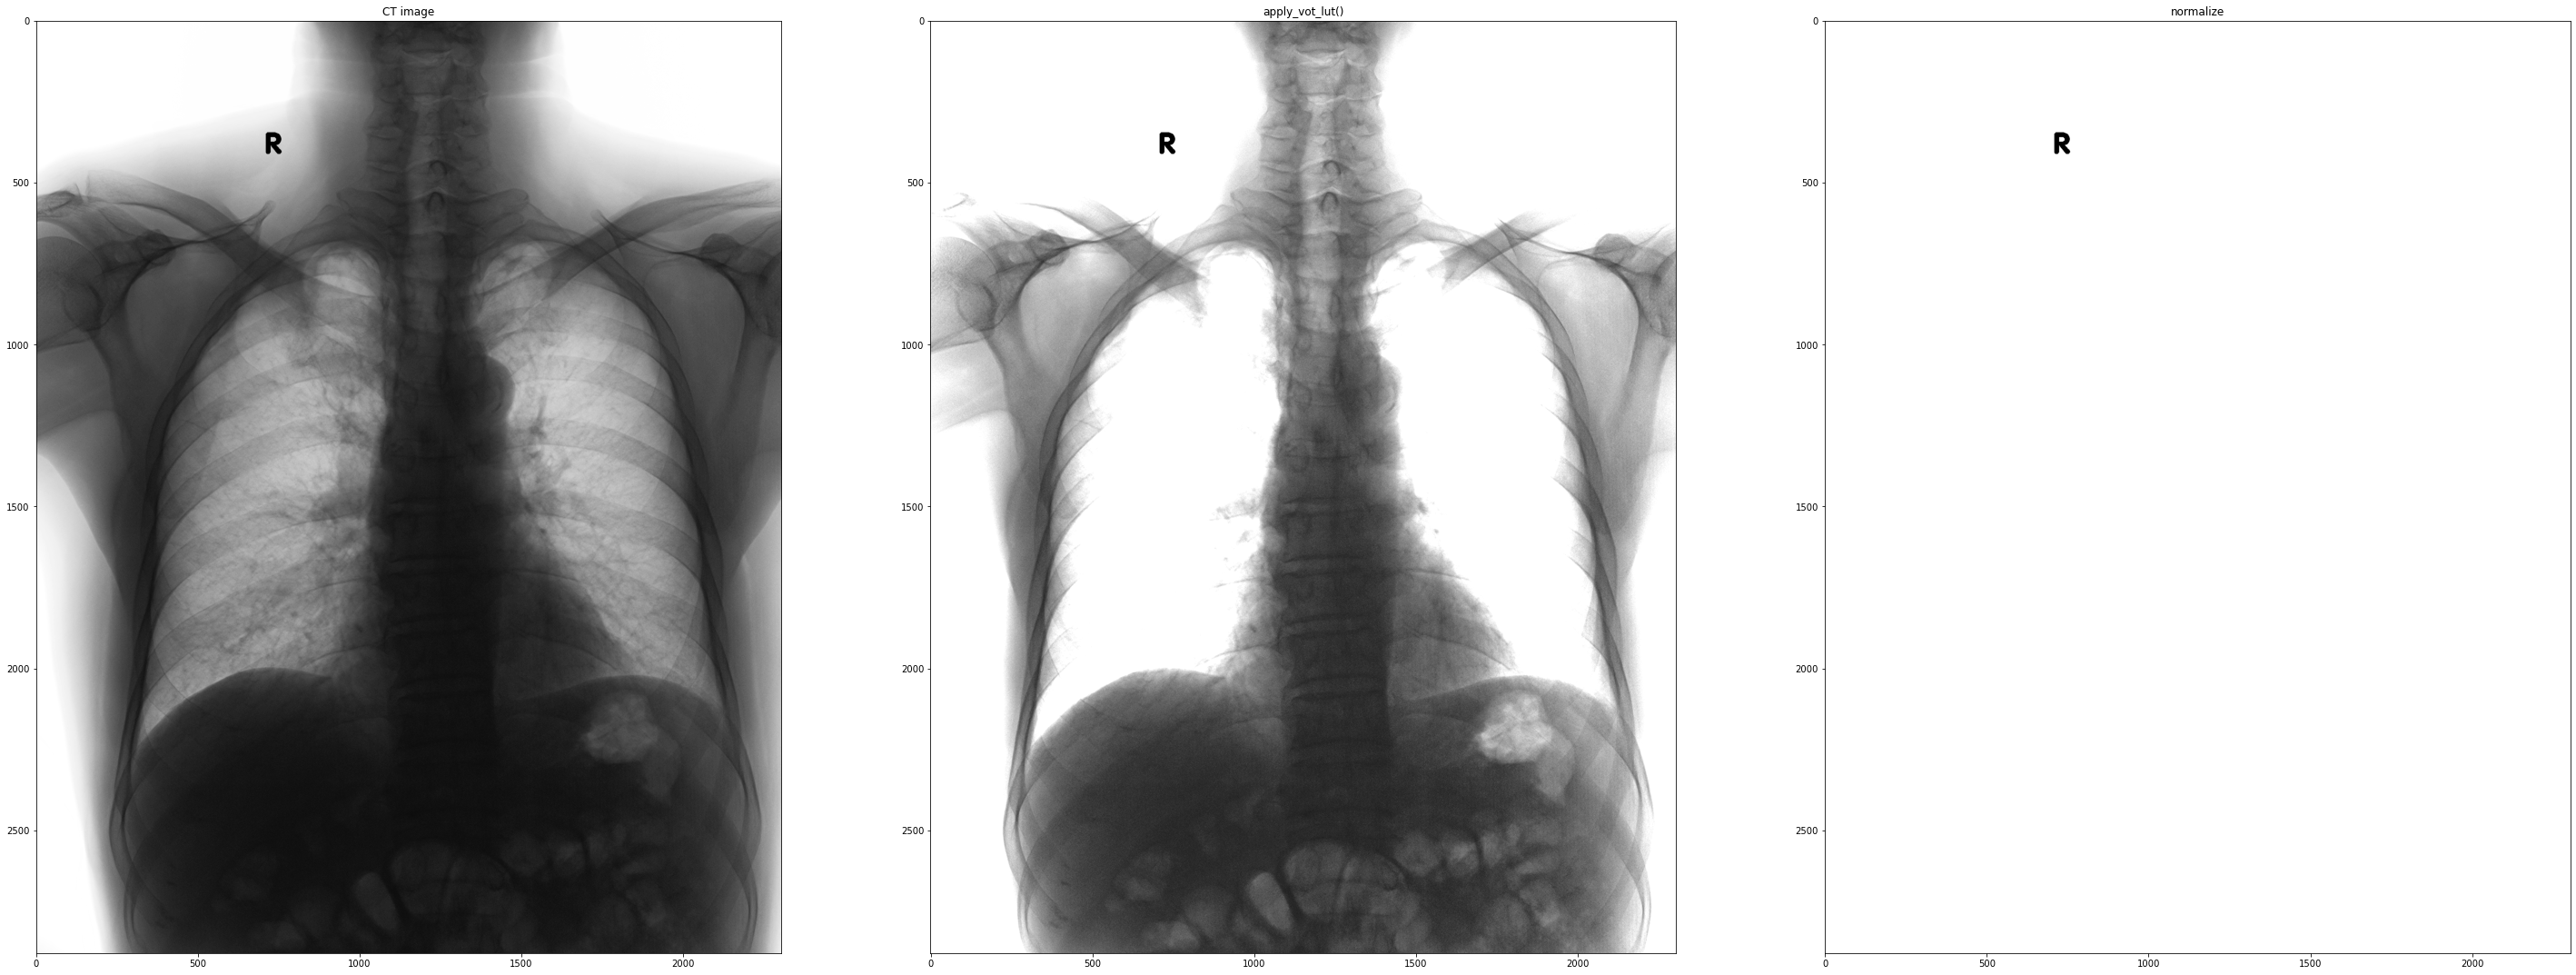

In [64]:
import numpy as np
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut

plt.figure(figsize=(50, 50))

img_read1 = pydicom.read_file(test_img)
s = int(img_read1.RescaleSlope)
b = int(img_read1.RescaleIntercept)
img1 = s * img_read1.pixel_array + b

# 단순 CT_image
plt.subplot(1, 3, 1)
plt.title('CT image')
plt.imshow(img1, cmap = 'gray')

# apply_modality_lut() 와 apply_voi_lut()를 해준 image
img_read1.WindowCenter = -400
img_read1.windowWidth = 1000

img1 = apply_modality_lut(img1, img_read1)
img1_1 = apply_voi_lut(img1, img_read1)
plt.subplot(1, 3, 2)
plt.title('apply_vot_lut()')
plt.imshow(img1_1, cmap = 'gray')

위와 같이 이미지를 불러들여 읽어낼 수 있었다.

# Chest X-ray Abnormalities Detection
## Data Analysis
Train Data 탐색

[Columns]<br>
image_id - 이미지와 매칭하기 위한 고유 식별자<br>
class_name - 감지된 개체의 클래스 이름(혹은 No finding)<br>
class_id - 감지된 개체의 클래스 ID<br>
rad_id - 관찰한 방사선 전문의의 ID<br>
x_min -  bounding box의 최소 X좌표<br>
y_min -  bounding box의 최소 y좌표<br>
x_max -  bounding box의 최대 x좌표<br>
y_min -  bounding box의 최대 y좌표

<br><br>

[adiographic findings as listed]<br>
0 : Aortic enlargement (대동맥 확장)<br>
1 : Atelectasis (무기폐-폐가 팽창된 상태를 유지하지 못하고 쭈그러듬)<br>
2 : Calcification (폐 석회화)<br>
3 : Cardiomegaly (심장 비대)<br>
4 : Consolidation (폐 경화)<br>
5 : ILD (간질성 폐질환)<br>
6 : Infiltration (침투-조직이나 세포에 정상이 아닌 물질이나 비정상적으로 과다한 물질이 축적, 침착하는 것)<br>
7 : Lung Opacity (비특이적으로 음영이 증가)<br>
8 : Nodule/Mass (결절/덩어리)<br>
9 : Other lesion (기타 병변)<br>
10 : Pleural effusion (흉막 삼출-흉강 내에, 혈장성 액체나 삼출액이 축적되는 것으로 그 원인으로는 염증, 종양, 심부전 등)<br>
11 : Pleural thickening (흉막 비후-흉막조직이나 기관이 과형성되어 두툼해진 상태)<br>
12 : Pneumothorax (기흉)<br>
13 : Pulmonary fibrosis (폐 섬유증)<br>

In [ ]:
!pip install keras
!pip install tensorflow

In [10]:
!pip install --upgrade albumentations

In [6]:
import albumentations as A

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns

import pandas as pd
import numpy as np
import random
import os

from pydicom import dcmread
import pydicom
import pylibjpeg

from keras.utils import np_utils

import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
train_data = pd.read_csv('./Chest_Xray/train.csv')
train_data

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [88]:
print(f'Train Data Size : {train_data.shape[0]}')
print(f'Train Data Columns : {train_data.keys()}', '\n\n')
print(train_data.info())

Train Data Size : 67914
Train Data Columns : Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max'],
      dtype='object') 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB
None


Train Data Size : 67914<br>
Train Data Columns : Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max'], dtype='object') 
<br>
Train Data info :<br>
```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
#   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
0   image_id    67914 non-null  object 
1   class_name  67914 non-null  object 
2   class_id    67914 non-null  int64  
3   rad_id      67914 non-null  object 
4   x_min       36096 non-null  float64
5   y_min       36096 non-null  float64
6   x_max       36096 non-null  float64
7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
```

In [5]:
len(train_data.image_id.unique())

15000

Image Data : 15,000장의 train dataset / 3000장의 test dataset<br>
테이블의 갯수가 이미지의 수보다 훨씬 많은 이유는<br>
한 이미지 안에 여러 종류의 질병이 동시에 예측되고 있기 때문이다.

## 15가지 분류 분포 확인

In [106]:
train_data.class_name.value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

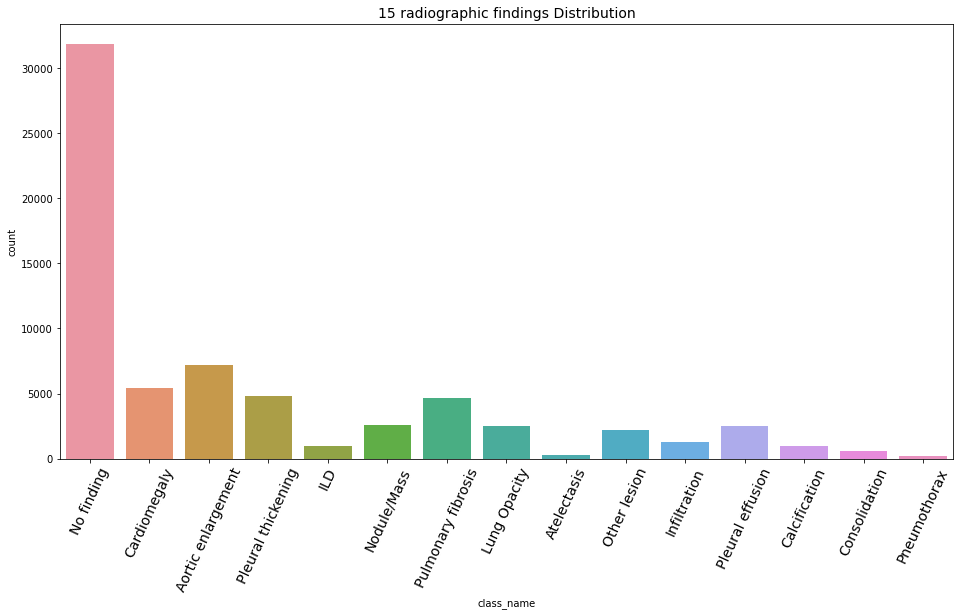

In [15]:
plt.figure(figsize=(16, 8))

sns.countplot(data = train_data, x = 'class_name')
plt.xticks(fontsize=14,rotation=65)
plt.title("15 radiographic findings Distribution", fontsize = 14)
plt.show()

## 가장 많이 잡힌 No finding을 제외하고
14가지의 질병 조사 결과만 비율(%)과 함께 확인

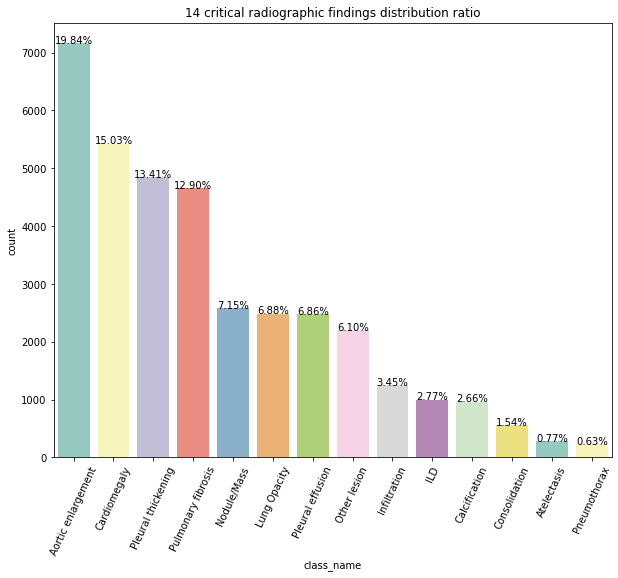

In [ ]:
x = train_data['class_name'].value_counts().keys()
y = train_data['class_name'].value_counts().values

train_data_1 = train_data[train_data['class_name']!='No finding']
f, ax = plt.subplots(1,1, figsize=(10,8))
total = float(len(train_data_1))
ax.set_xticklabels(x, rotation=65)
plt.title("14 critical radiographic findings distribution ratio")
sns.countplot(train_data_1['class_name'],
              order = train_data_1['class_name'].value_counts().index,
              palette='Set3')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 

plt.show()

## 샘플 이미지
무작위로 Class_id를 골라 2장씩 총 16장의 Sample Image를 추출한 뒤 Train Data를 활용하여 바운딩 박스를 그려주었다.

[[2871 2858 2833 ... 3973 3977 3988]
 [3064 3033 3022 ... 3999 4003 4002]
 [3241 3207 3193 ... 4014 4013 4016]
 ...
 [4087 4089 4083 ... 4089 4095 4093]
 [4087 4089 4082 ... 4088 4095 4093]
 [4087 4090 4083 ... 4089 4095 4093]]


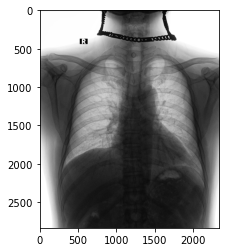

In [6]:
dicom = pydicom.dcmread("./Chest_Xray/train/000434271f63a053c4128a0ba6352c7f.dicom")
img = dicom.pixel_array
print(img)
plt.imshow(img, cmap = 'gray')

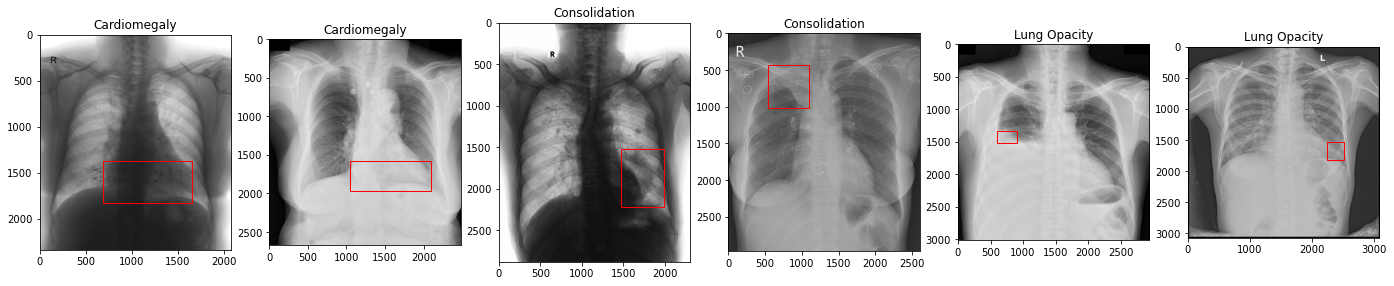

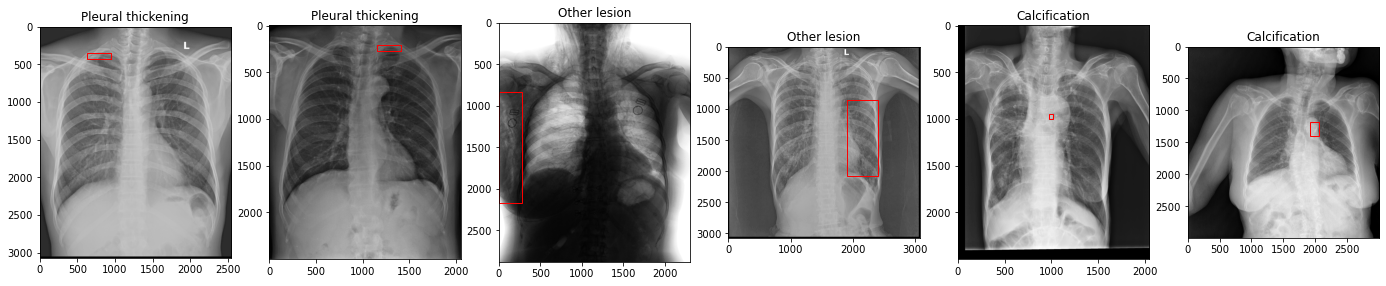

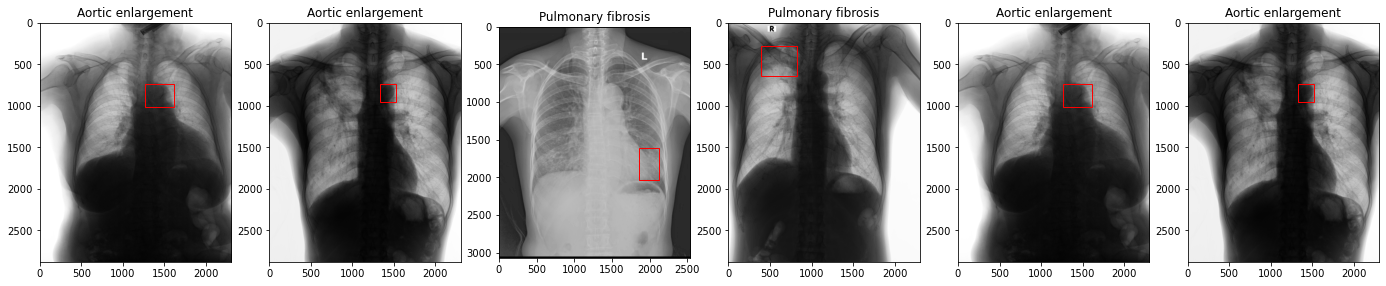

In [6]:
train_dir = './Chest_Xray/train/'
train_files = os.listdir(train_dir)

def plot_example(idx_list):
    # 한 장에 여러 이미지(6장)를(을) 담을 것이다
    # fig, axes = plt.subplots(1, 6) = 6개(1*6; 한줄에 6장)의 ax들을 가지는 하나의 figure 생성
    fig, axs = plt.subplots(1, 6, figsize=(24, 10))
    
    # 서브 플롯 간의 간격 맞추기
    # subplots_adjust(left, bottom, right, top, wspace, hspace)
    # (left, bottom, right, top=4면의 위치 조정)
    # (wspace, hspace=너비와 높이 비율조절)
    fig.subplots_adjust(hspace = .2, wspace=.2)
    
    # flatten = 다차원 배열을 1차원 배열로 평평하게
    axs = axs.flatten()
    
    # 6개씩
    for i in range(6):
        # train_data에 있는 image_id는 X-ray사진과 매칭되는 파일명
        # idx_list에 담겨져 있는 0번째 .... 6번째 를 돌면서 파일명을 가져온다
        image_id = train_data.loc[idx_list[i], 'image_id']
        
        # CT 사진파일에 접근
        data_file = pydicom.dcmread(train_dir + image_id+'.dicom')
        
        # 시각화 하기 위해 배열로 변환
        img = data_file.pixel_array
        axs[i].imshow(img, cmap='gray')
        
        # 서브 플롯당 제목 설정
        axs[i].set_title(train_data.loc[idx_list[i], 'class_name'])
        
        # box 정보가 없는 Nofinding을 제외하고
        if train_data.loc[idx_list[i], 'class_name'] != 'No finding':
            
            bbox = [train_data.loc[idx_list[i], 'x_min'],
                    train_data.loc[idx_list[i], 'y_min'],
                    train_data.loc[idx_list[i], 'x_max'],
                    train_data.loc[idx_list[i], 'y_max']]
            
            # matplotlib.patches.Rectangle = 도형 시각화
            # ((x, y), width, height)
            p = matplotlib.patches.Rectangle((bbox[0], bbox[1]),
                                             bbox[2]-bbox[0],
                                             bbox[3]-bbox[1],
                                             # ec(=edgecolor; 테두리 색)
                                             # fc(=facecolor; 면 색)
                                             # lw(=linewidth; 선 굵기)
                                             ec='r', fc='None', lw=1)
            # add_patch = 도형 시각화
            axs[i].add_patch(p)

# 3줄 뽑아줄거다
for num in range(3):
    a = int(random.random())
    idx_list = train_data[train_data['class_id'] == random.randint(0, 14)][a:a+2].index.values
    idx_list = np.append(idx_list, train_data[train_data['class_id'] == random.randint(0, 14)][a:a+2].index.values)
    idx_list = np.append(idx_list, train_data[train_data['class_id'] == random.randint(0, 14)][a:a+2].index.values)
    # print(idx_list)
    plot_example(idx_list)

## 사용하기 편하도록 Train_csv 변경하기
x_min, y_min, x_max, y_max의 값이 없으니까 임의로 값을 넣어주려 한다.

In [3]:
train_data_handle = train_data
train_data_handle = train_data_handle.fillna(0.1)
train_data_handle[:5]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,0.1,0.1,0.1,0.1
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,0.1,0.1,0.1,0.1
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,0.1,0.1,0.1,0.1


이미지 불러오는 편의를 위해 경로 컬럼 추가<br>

In [4]:
train_img_path = './Chest_Xray/train/'
img_path = []
for i in train_data_handle['image_id']:
    img_path.append(train_img_path + i+'.dicom')

train_data_handle['img_path'] = img_path
train_data_handle[:3]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,img_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,0.1,0.1,0.1,0.1,./Chest_Xray/train/50a418190bc3fb1ef1633bf9678...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,0.1,0.1,0.1,0.1,./Chest_Xray/train/21a10246a5ec7af151081d0cd6d...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,./Chest_Xray/train/9a5094b2563a1ef3ff50dc5c7ff...


### visualizing path image
추가된 경로로 이미지 불러와보기

(2580, 2332)


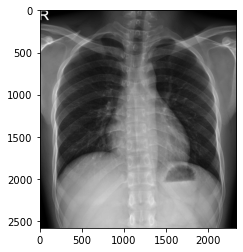

(3159, 2954)


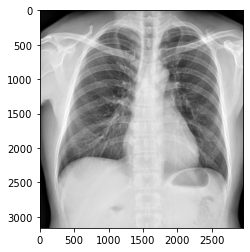

(2336, 2080)


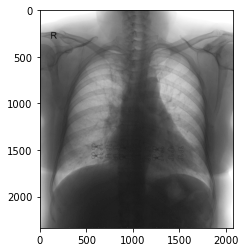

In [7]:
for i in range(3): 
    img_test = pydicom.dcmread(train_data_handle.iloc[i].img_path)
    img_test= img_test.pixel_array
    plt.imshow(img_test, cmap='gray')
    print(img_test.shape)
    plt.show()

### 이미지 사이즈 및 박스 값 변경

(512, 512)


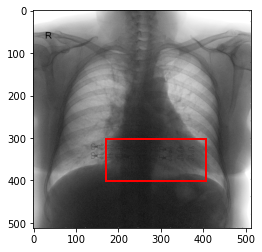

(512, 512)


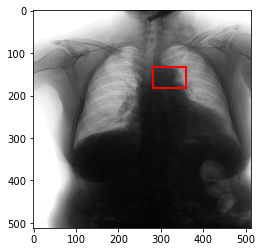

(512, 512)


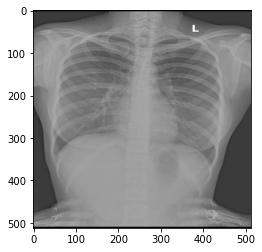

In [11]:
# 이미지 설정(train : 1821, test : 1821)
IMAGE_SHAPE = [512, 512]
transforms_train = A.Compose([
    A.Resize(height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1], p=1.0)],
    bbox_params = A.BboxParams(format='pascal_voc'))

for i in range(3):
    i += 2
    img_test = pydicom.dcmread(train_data_handle.iloc[i].img_path)
    img_test = img_test.pixel_array
    
    if (train_data_handle.iloc[i].x_max == train_data_handle.iloc[i].x_min) :
        xmax_temp = train_data_handle.iloc[i].x_max + 0.01
    else :
        xmax_temp = train_data_handle.iloc[i].x_max
    
    if (train_data_handle.iloc[i].y_max == train_data_handle.iloc[i].y_min) :
        ymax_temp = train_data_handle.iloc[i].y_max + 0.01
    else :
        ymax_temp = train_data_handle.iloc[i].y_max
    
        
    xmin, ymin, xmax, ymax = [train_data_handle.iloc[i].x_min,
                              train_data_handle.iloc[i].y_min,
                              xmax_temp,
                              ymax_temp]
    
    img_bbox = [[xmin, ymin, xmax, ymax, 'boxes']]
    # print(img_bbox)
    
    transformed = transforms_train(image = img_test, bboxes = img_bbox)
    transformed_img = transformed['image']
    transformed_bboxes = transformed['bboxes']
    # print(transformed['bboxes'])
    plt.imshow(transformed_img, cmap='gray')
    
    for j in transformed_bboxes :
        xmin, ymin, xmax, ymax = transformed_bboxes[0][0], transformed_bboxes[0][1], transformed_bboxes[0][2], transformed_bboxes[0][3]
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='red', fill=False)
        ax = plt.gca()
        ax.add_patch(rect)
    
    print(transformed_img.shape)
    # print(xmin, ymin, xmax, ymax)
    plt.show()

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_data_handle1 = train_data_handle.copy()
train_data_handle1[['x_min', 'y_min', 'x_max', 'y_max']] = scaler.fit_transform(train_data_handle[['x_min', 'y_min', 'x_max', 'y_max']])
train_data_handle1[['x_min', 'y_min', 'x_max', 'y_max']] = (train_data_handle1[['x_min', 'y_min', 'x_max', 'y_max']]*730).astype(int)
train_data_handle1

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,img_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,0,0,0,0,./Chest_Xray/train/50a418190bc3fb1ef1633bf9678...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,0,0,0,0,./Chest_Xray/train/21a10246a5ec7af151081d0cd6d...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,171,320,385,394,./Chest_Xray/train/9a5094b2563a1ef3ff50dc5c7ff...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,314,173,375,219,./Chest_Xray/train/051132a778e61a86eb147c7c6f5...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,0,0,0,0,./Chest_Xray/train/063319de25ce7edb9b1c6b88812...
...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,0,0,0,0,./Chest_Xray/train/936fd5cff1c058d39817a08f58b...
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,0,0,0,0,./Chest_Xray/train/ca7e72954550eeb610fe22bf024...
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,0,0,0,0,./Chest_Xray/train/aa17d5312a0fb4a2939436abca7...
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,191,228,391,282,./Chest_Xray/train/4b56bc6d22b192f075f13231419...


In [58]:
# sample 하나에 있는 bbox 정보 가져오기
temp_data = train_data_handle1[train_data_handle1['image_id'] == '9a5094b2563a1ef3ff50dc5c7ff71345']
temp_data = temp_data[['x_min', 'y_min', 'x_max', 'y_max']]
temp_data

,x_min,y_min,x_max,y_max
2,171,320,385,394
5517,445,402,437,429
25023,445,402,437,429
26165,172,320,386,388
42709,171,305,388,380
53473,261,166,302,208


In [59]:
train_data_handle1[train_data_handle1.image_id == '9a5094b2563a1ef3ff50dc5c7ff71345']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,img_path
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,171,320,385,394,./Chest_Xray/train/9a5094b2563a1ef3ff50dc5c7ff...
5517,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,445,402,437,429,./Chest_Xray/train/9a5094b2563a1ef3ff50dc5c7ff...
25023,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,445,402,437,429,./Chest_Xray/train/9a5094b2563a1ef3ff50dc5c7ff...
26165,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,172,320,386,388,./Chest_Xray/train/9a5094b2563a1ef3ff50dc5c7ff...
42709,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,171,305,388,380,./Chest_Xray/train/9a5094b2563a1ef3ff50dc5c7ff...
53473,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,0,R9,261,166,302,208,./Chest_Xray/train/9a5094b2563a1ef3ff50dc5c7ff...


In [60]:
bbox_list = [] #sample하나에 있는 bbox list를 넣어줌.
for i in range(len(temp_data)):
    bbox_list.append(temp_data.iloc[i].tolist())
bbox_list

[[171, 320, 385, 394],
 [445, 402, 437, 429],
 [445, 402, 437, 429],
 [172, 320, 386, 388],
 [171, 305, 388, 380],
 [261, 166, 302, 208]]

In [61]:
bbox0 = np.array(bbox_list)
bbox0

array([[171, 320, 385, 394],
       [445, 402, 437, 429],
       [445, 402, 437, 429],
       [172, 320, 386, 388],
       [171, 305, 388, 380],
       [261, 166, 302, 208]])

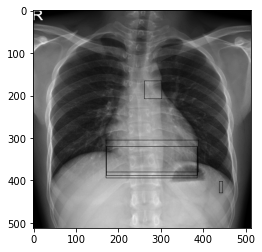

In [74]:
transforms_train = A.Compose([
    A.Resize(height=512, width=512, p=1.0)
])

img1 = pydicom.dcmread(train_data_handle1.iloc[0].img_path)
img1 = img1.pixel_array

transformed = transforms_train(image = img1)
transformed_img = transformed['image']

for i in range(len(bbox_list)):
    cv2.rectangle(transformed_img, (bbox0[i][0],bbox0[i][1]),(bbox0[i][2], bbox0[i][3]), color=(0, 255, 0), thickness=1)
plt.imshow(transformed_img, cmap='gray')
plt.show()

## 다중 분류기(multicalss classifier)
다중 분류를 하는 방법은 두가지인것 같다<br>
SGDClassifier나 RandomForestClassifier 와 같은 여러 클래스를 직접 처리할 수 있는 다중 분류기를 이용하거나, 로지스틱 회귀나 SVM과 같은 이진 분류기를 여러개 훈련시켜 분류 시스템을 만드는 방법<br><br>

예를 들어 하나의 숫자만 구분하는 숫자별 이진 분류기를 10개 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만드는 방법인데. 이비지 분류시 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 된다. 이를 OvR(one-versus-the-rest or one-versus-all)전략이라고 부른다고 함
<br><br>


## 이미지 전체 가져오기
### Image loader

In [25]:
dicom.parent

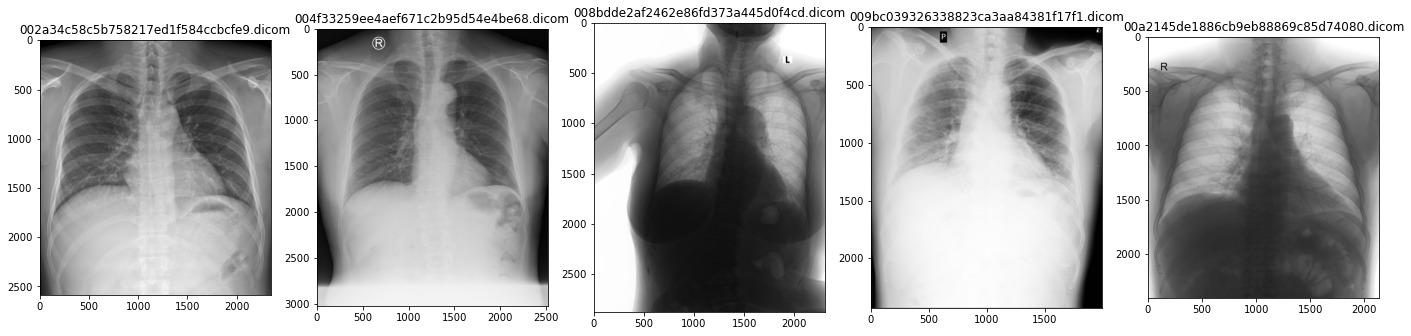

In [29]:
train_dir = './Chest_Xray/train/'
test_dir = './Chest_Xray/test/'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# for file_name in train_files :
#     if (file_name.startswith(".") == False) :
#         train_path = train_dir + file_name
#         print(train_path)

fig, axs = plt.subplots(1, 5, figsize=(24, 8))
i = 0

for file_name in test_files[:5] :
    test_path = test_dir + file_name
    # print(test_path)
    file_img = pydicom.dcmread(test_path)
    axs[i].set_title(file_name.replace("./*/", ""))
    
    img = file_img.pixel_array
    
    axs[i].imshow(img, cmap='gray')
    i += 1

In [40]:
# train_dir = './Chest_Xray/train/'
# train_files = os.listdir(train_dir)

# images = []
# test_images = []

# image_ids = list(train_data.image_id)

# for image_id in image_ids:
#     train_path = train_dir + file_name
#     images.append(train_path + '.dicom')

# print(images)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_target, test_size=0.3, random_state=156)

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [12]:
np_utils.to_categorical(train_data.class_id, 15)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

keras는 인공지능 코딩을 쉽게하기 위한 간결하고 직관적인 API를 제공하는 파이썬 라이브러리 이다.<br>
tensorflow는 구글에서 만들어진 머신러닝 및 딥러닝 프레임 워크<br>
<br>
→ tensorflow는 Keras의 기본 백엔드

In [111]:
# tensorflow 사용
! pip install tensorflow
! pip install -q tensorflow-gpu==2.5.0-rc1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc1
